In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Credit to Dr. Trevor Harris (STAT 335)

# Simple Linear Regression

A linear regression model using the predictor $X_i$ is : 

$$ f(X_i) = \beta_0 + \beta_1 X_i $$

We assume that the deterministic relationship is just a line
 - $\beta_0$ is the __intercept__
 - $\beta_1$ is the __slope__

We will use $f(X_i)$ to predict $Y_i$ for each $i = 1,...,n$. So, the model for $Y$ is: 

$$Y = f(X) + \epsilon = \beta_0 + \beta_1 X + \epsilon $$.


$\epsilon_i = Y_i - f(X_i)$ = Residual Error for $i^{th}$ observation.


# Multiple Linear Regression

Lets extend the linear regression case to the case where we have $p$ variables that we want to use to predict $Y$
 - More information is better!

So the model for $Y$ is

$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_p X_p + \epsilon $$

This is simply a linear regression model with more than one predictor

# Interaction terms

__Interaction__: An interaction occurs when an independent variable has a different effect on the outcome depending on the values of another independent variable.

Iteraction terms measure how the response $Y$ is affected by two variables simultaneously

Can create interaction terms by simply multiplying covariates together. For example if we have two variables $X_1$ and $X_2$. We can measure the individual contributions of $X_1$ and $X_2$ and interaction contribuion $X_1 X_2$ as 

$$
f(x) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1 X_2
$$

# Titanic Dataset (again)

Even though regression is not actually the ideal algorithm for this dataset, we will learn about the strengths and weaknesses that will give motivation for other alternatives.

In [66]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

import IPython

In [67]:
data = pd.read_csv('/content/drive/Shareddrives/Aggie Data Science Club/Workshops/2022-11-1 Workshop/titanic.csv')

In [68]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [69]:
df = data
df = data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
df = df.dropna()
df.shape

(712, 8)

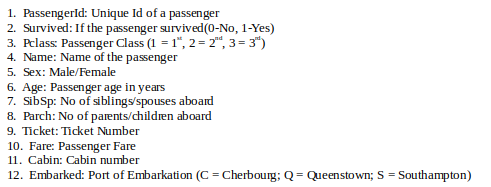

In [70]:
IPython.display.Image('/content/drive/Shareddrives/Aggie Data Science Club/Workshops/2022-11-1 Workshop/titanic_attributes.png', width = 600)

# Quantitative Variables

Completely numerical with no categorical distinctions. Can be **discrete or continuous** based on the types of values the variable can have (e.g. whole numbers vs rational).

* PassengerId (irrelevant)
* Age
* SibSp
* Parch
* Ticket (debatable but irrelevant)
* Fare
* Cabin (irrelevant because no spatial meaning given, every single cabin will be different)

In [71]:
x_quant = df.loc[:, ["Age", "SibSp", "Parch", "Fare"]]

# Qualitative or Categorical Variables

Categorical distinctions. Number of categories is usually significantly smaller than the number of observations (otherwise, can be quantitative). Can be **nominal or ordinal**. Nominal variables have no particular order (e.g. color), while ordinal variables have a natural/intuitive order (e.g. ranking).

* Survived (nominal but does not matter since binary)
* Pclass (ordinal)
* Name (nominal but irrelevant)
* Sex (nominal)
* Embarked (nominal)

In [72]:
# look at category counts for each attribute to verify

df["Sex"].value_counts()

male      453
female    259
Name: Sex, dtype: int64

Categorical variables oftentimes need to be encoded into numerical values that can be piped into ML algorithms. **Ordinal variables** have an intuitive order, so if they are given numerically, they can usually be kept intact. On the other hand, **nominal variables** need to be encoded.

Many methods of encoding, but one method is **one-hot encoding**.

* For each of the $k$ categories, there are $k$ dummy features (or columns) created
* Mark each entry as 0 or 1 based on whether it belongs to the given category

A better method is **dummy encoding**.

* Same as one-hot encoding except there are $k-1$ new dummy features (dropped one category)
* Dropped category serves as the baseline, other categories measure difference from baseline

In [73]:
from sklearn.preprocessing import OneHotEncoder

x_nom = df.loc[:,["Sex", "Embarked"]]

enc = OneHotEncoder()
enc.fit(x_nom)

x_cat = enc.transform(x_nom).toarray()

print(x_cat.shape)
print(["{}: {} categories".format(col, len(df[col].value_counts())) for col in x_nom.columns])

(712, 5)
['Sex: 2 categories', 'Embarked: 3 categories']


# Linear Regression in scikit-learn

Sci-kit learn abstracts much of the inner mathematics (minimizing loss functions, error optimization, etc.) These details are important to understand, but usually better to rely on built-in functions.

First, identify the response/independent variable of interest.

In [74]:
# predict whether people survived

y = df.loc[:, ["Survived"]]

Now, accumulate all the predictors/covariates/dependent variables of interest. Correctly process quantitative and qualitative variables. Then, concatenate everything into a stack of variables.

In [75]:
# best combo: ["Age", "SibSp"], ["Pclass"], ["Sex"]

# select quantitative features
x_quant = df.loc[:, ["Age", "SibSp", "Parch", "Fare"]]

# ordinal (already encoded)
x_ord = df.loc[:, ["Pclass"]]


# encode categorical features
x_nom = df.loc[:,["Sex", "Embarked"]]

enc = OneHotEncoder()
enc.fit(x_nom)

x_cat = enc.transform(x_nom).toarray()


# create interaction features (need to use np arrays for dimensions)
x_int_fare_pclass = np.array(df.loc[:, ["Fare"]]) * np.array(df.loc[:, ["Pclass"]])

# concatenate all features into a single covariate array x
x = np.hstack([x_quant, x_ord, x_cat])

Split data into training and testing sets. We will train the model on the training data, and then test the fit with the testing data.

In [76]:
# splits into training and testing for each of x and y based on test_size
# from sklearn.model_selection --> train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

Fit the model and make predictions. yhat indicates predictions based on the model.

In [77]:
from sklearn.linear_model import LinearRegression

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

lm = LinearRegression()
lm.fit(x_train, y_train)
yhat_train = lm.predict(x_train)
yhat_test = lm.predict(x_test)

# Judging the Model with MSE and $R^2$

Certain numerical metrics can be used to gauge the correctness, accuracy, and validity of a model.

**MSE, or mean square error,** measures the average residual between expected and actual values. We can calculate this manually based on the values we predicted.

**$R^2$, or coefficient of determination** measures the amount of variation in the predictor explained by the model. sklearn provides a function to calculate this value for a model.

The goal is to **minimize MSE and maximize $R^2$** for the testing dataset, which means we have an accurate model that effectively predicts the independent variable. We can also compare the metrics from training to testing to see whether the model generalizes well.

In [78]:
print("Train")
print('MSE -', np.mean((y_train - yhat_train)**2))
print('R2 - ', lm.score(x_train, y_train))

print()

print("Test")
print('MSE -', np.mean((y_test - yhat_test)**2))
print('R2 - ', lm.score(x_test, y_test))

Train
MSE - 0.13298619181969035
R2 -  0.44410980234894304

Test
MSE - 0.17220568484814305
R2 -  0.29366763623449954


# Hypothesis Testing for Model Correctness

A more in-depth analysis of the effects of individual variables would be helpful for guiding us when modifying the model.

The following regression results table contains a lot of information, but the most important is the second section listing attributes of each term in the regression equation $\hat{y} = \beta_0 + \beta_1 * x_1 + ... + \beta_p * x_p$.

Each term relates to a predictor that we passed in when fitting the model (same order as stack). The most important columns are **P>|t|** and **[0.025 0.975]**.

**P>|t|** describes the p-value that the null hypothesis $H_{0_i}$ is true, where $H_{0_i}: \beta_i = 0$. This means that specific predictor is not significant and does not contribute to the response variable. Therefore, if the p-value is low, we can reject the null and claim that the predictor is significant.

**[0.025 0.975]** is very similar. If 0 is NOT in the 95% confidence interval, then we can reject $H_{0_i}$ and claim that the given predictor is significant.

In [79]:
import statsmodels.api as sm

x_train2 = sm.add_constant(x_train)
est = sm.OLS(y_train, x_train2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     46.74
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           4.14e-55
Time:                        23:31:51   Log-Likelihood:                -195.66
No. Observations:                 477   AIC:                             409.3
Df Residuals:                     468   BIC:                             446.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6715      0.054     12.514      0.0

# Logistic Regression

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#ignore these next three
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [81]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [82]:
dummies = ['Fare', 'Age', 'Embarked', 'Sex']
dummy_data = pd.get_dummies(df[dummies])

In [83]:
df_dummies = pd.concat([df, dummy_data], axis = 1)
df_dummies.drop(dummies, axis=1, inplace=True)

In [84]:
df_dummies.head()

,Survived,Pclass,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,0,3,1,0,0,0,1,0,1
1,1,1,1,0,1,0,0,1,0
2,1,3,0,0,0,0,1,1,0
3,1,1,1,0,0,0,1,1,0
4,0,3,0,0,0,0,1,0,1


In [85]:
X = df_dummies.drop('Survived', axis = 1)
y = df_dummies['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [86]:
log_reg = LogisticRegression(penalty='l2') #Penalty/regularization is optional
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

In [87]:
accuracy_score(y_pred, y_test)

0.7692307692307693

In [88]:
confusion_matrix(y_pred, y_test)

array([[60, 19],
       [14, 50]])

69 true negatives, 19 false negatives, 13 false positives, 42 true positives

In [89]:
report = classification_report(y_pred, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.76      0.78        79
           1       0.72      0.78      0.75        64

    accuracy                           0.77       143
   macro avg       0.77      0.77      0.77       143
weighted avg       0.77      0.77      0.77       143



# Drop-in models that we will not be explaining

In [90]:
clf_poly = SVC(kernel="poly")
clf_poly.fit(X_train, y_train)

clf_lin = SVC(kernel="linear")
clf_lin.fit(X_train, y_train)

clf_rbf = SVC(kernel="rbf")
clf_rbf.fit(X_train, y_train)

SVC()

In [91]:
poly_pred = clf_poly.predict(X_test)
lin_pred = clf_lin.predict(X_test)
rbf_pred = clf_rbf.predict(X_test)

In [92]:
poly_report = classification_report(y_test,poly_pred)
poly_matrix = confusion_matrix(y_test,poly_pred)
print(poly_report)
print(poly_matrix)

              precision    recall  f1-score   support

           0       0.76      0.88      0.81        74
           1       0.84      0.70      0.76        69

    accuracy                           0.79       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.80      0.79      0.79       143

[[65  9]
 [21 48]]


In [93]:
lin_report = classification_report(y_test,lin_pred)
lin_matrix = confusion_matrix(y_test,lin_pred)
print(lin_report)
print(lin_matrix)

              precision    recall  f1-score   support

           0       0.75      0.82      0.79        74
           1       0.79      0.71      0.75        69

    accuracy                           0.77       143
   macro avg       0.77      0.77      0.77       143
weighted avg       0.77      0.77      0.77       143

[[61 13]
 [20 49]]


In [94]:
rbf_report = classification_report(y_test,rbf_pred)
rbf_matrix = confusion_matrix(y_test,rbf_pred)
print(rbf_report)
print(rbf_matrix)

              precision    recall  f1-score   support

           0       0.76      0.88      0.81        74
           1       0.84      0.70      0.76        69

    accuracy                           0.79       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.80      0.79      0.79       143

[[65  9]
 [21 48]]


In [95]:
rf_model = RandomForestClassifier(n_estimators=1000)
rf_model.fit(X_train,y_train)
rf_pred = rf_model.predict(X_test)
rf_matrix = confusion_matrix(y_test,rf_pred)

In [96]:
print(classification_report(y_test,rf_pred))
print(rf_matrix)


              precision    recall  f1-score   support

           0       0.74      0.84      0.78        74
           1       0.80      0.68      0.73        69

    accuracy                           0.76       143
   macro avg       0.77      0.76      0.76       143
weighted avg       0.77      0.76      0.76       143

[[62 12]
 [22 47]]


In [97]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
neigh_pred = neigh.predict(X_test)
neigh_matrix = confusion_matrix(y_test,neigh_pred)

In [98]:
print(classification_report(y_test,neigh_pred))
print(neigh_matrix)

              precision    recall  f1-score   support

           0       0.76      0.84      0.79        74
           1       0.80      0.71      0.75        69

    accuracy                           0.78       143
   macro avg       0.78      0.77      0.77       143
weighted avg       0.78      0.78      0.78       143

[[62 12]
 [20 49]]
